In [318]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr, kendalltau, spearmanr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, brute, minimize
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

Carrega a base de média diária de voos

In [319]:
international_flights_avg = pd.read_csv('jan-media_voos.csv')
international_flights_avg = international_flights_avg[['org', 'dest', 'valor_norm']]
international_flights_avg = international_flights_avg.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})

In [320]:
international_flights_avg.head()

,source,target,value
0,Algeria,Austria,1.000000
1,Algeria,Belgium,1.275510
2,Algeria,Canada,1.000000
3,Algeria,France,12.272727
4,Algeria,Germany,1.560345


Constrói o grafo com a probabilidade de voos entre países

In [321]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()

transition_matrix = transition_matrix.set_index('source').join(country_international_flights, lsuffix='_daily_flights', rsuffix='_source_sum_flights')

transition_matrix['prob'] = (transition_matrix['value_daily_flights']/transition_matrix['value_source_sum_flights'])
transition_matrix = transition_matrix.drop(columns=['value_source_sum_flights', 'value_daily_flights']).reset_index()

In [322]:
transition_matrix.head()

,source,target,prob
0,Algeria,Austria,0.027296
1,Algeria,Belgium,0.034816
2,Algeria,Canada,0.027296
3,Algeria,France,0.334996
4,Algeria,Germany,0.042591


In [323]:
transition_matrix.groupby('source')[['prob']].sum()

,prob
source,
Algeria,1.0
Argentina,1.0
Armenia,1.0
Australia,1.0
Austria,1.0
Bahrain,1.0
Bangladesh,1.0
Barbados,1.0
Belarus,1.0


Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [324]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])



In [325]:
countries = transition_matrix['source'].unique()

def get_cases(day=77):
    cases = total_cases.xs(day, level=1).reindex(countries).fillna(0)

    cases = cases.rename(columns={'Total': 'n_cases'}) 
    return cases

daily_cases = get_cases()

In [326]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no votor abaixo 

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix['source'].unique())
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


Faz o random walk

In [327]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [328]:
transition_matrix = transition_matrix.set_index(['source', 'target'])

In [329]:
def transition_matrix_loss(loss_df):    
    df_joined = transition_matrix.join(loss_df, how='left')

    df_joined['prob'] = df_joined['prob']*df_joined['pct_loss']

    df_joined = df_joined.reset_index()

    df_joined = pd.crosstab(df_joined['target'], df_joined['source'], df_joined['prob'], aggfunc=sum)
    df_joined = df_joined.fillna(0)

    return df_joined

In [330]:
week_loss_df = pd.read_csv('data/week_pct_loss.csv').drop(columns=['Unnamed: 0']).rename(columns={'org': 'source', 'dest':'target'})

In [331]:
tplFinal1=(0,0)

In [332]:
def model_spread2(r, p, use_loss=False, day=77):
    state_df = state_df_start
    
    for i in range(1, (day+1)):
        week = math.ceil(i/7)
        if(week<7):
            state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
        else:
            if use_loss:
                week_loss = week_loss_df.set_index(['week_value']).loc[week - 2].reset_index().set_index(['source', 'target']).drop(columns=['week_value'])
                transition_matrix_week =transition_matrix_loss(week_loss)
                state_df = state_df*r + (transition_matrix_week.dot(state_df)*p)
            else:
                state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
            
            
    return state_df

In [333]:
def model_optimize_mae(day=77, use_loss=False):
    cases = get_cases(day)['n_cases'].values
    
    # function we would like to fit
    get_predicted=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl: np.mean(np.abs(get_predicted(tpl)-cases))

    tpl_ranges=((1.001, 2), (0.00000001, 0.000005))

    tplFinal1=brute(ErrorFunc, tpl_ranges)
    
    print(" params ",tplFinal1)

    return pd.DataFrame({'CasesPredicted':get_predicted(tplFinal1)}, index=transition_matrix_crosstab.columns)
    

In [334]:
def model_optimize_sqr_mae(day=77, use_loss=False):
    cases = get_cases(day)['n_cases'].values
    
    # function we would like to fit
    get_predicted=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl: np.mean(np.sqrt(np.abs(get_predicted(tpl)-cases)))

    tpl_ranges=((1.001, 2), (0.00000001, 0.000005))

    tplFinal1=brute(ErrorFunc, tpl_ranges)
    
    print(" params ",tplFinal1)

    return pd.DataFrame({'CasesPredicted':get_predicted(tplFinal1)}, index=transition_matrix_crosstab.columns)
    

In [335]:
# function we would like to fit
get_predicted=lambda tpl : model_spread2(tpl[0], tpl[1], False, 77).T.values[0]
# ErrorFunc is the diference between the func and the y "experimental" data
ErrorFunc=lambda tpl: np.mean(np.abs(get_predicted(tpl)-cases))

tplInitial1=(1.001,0.0000001)

df = pd.DataFrame({'CasesPredicted':get_predicted(tplInitial1)}, index=transition_matrix_crosstab.columns)

df

,CasesPredicted
source,
Algeria,1.864618e-12
Argentina,1.377350e-12
Armenia,2.640537e-12
Australia,7.146049e-06
Austria,3.516306e-06
Bahrain,3.759156e-12
Bangladesh,3.077043e-12
Barbados,5.950891e-13
Belarus,3.874630e-12


In [336]:
def model_optimize_mae_gd(day=77, use_loss=False):
    cases = get_cases(day)['n_cases'].values
    
    # function we would like to fit
    get_predicted=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl: np.mean(np.abs(get_predicted(tpl)-cases))

    tplInitial1=(1.001,0.0000001)

    resp=minimize(ErrorFunc, tplInitial1, method="CG")
    
    tplFinal1=resp['x']
    
    print(" params ",tplFinal1, resp['success'], resp['message'])

    return pd.DataFrame({'CasesPredicted':get_predicted(tplFinal1)}, index=transition_matrix_crosstab.columns)
    

In [337]:
def model_optimize_leastsq(day=77, use_loss=False):
    cases = get_cases(day)
    # function we would like to fit
    func=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl,cases: func(tpl)-cases # np.sqrt(np.abs(func(tpl)-cases))
    #tplInitial contains the "first guess" of the parameters 
    tplInitial1=(1.001,0.0000001)
    # leastsq finds the set of parameters in the tuple tpl that minimizes
    # ErrorFunc=yfit-yExperimental
    tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(cases['n_cases'].values))
    print(" params ",tplFinal1)


    return pd.DataFrame({'CasesPredicted':func(tplFinal1)}, index=transition_matrix_crosstab.columns)
    

In [338]:
df_model_corr = pd.DataFrame({'Day':[], 'NoLoss':[], 'WithLoss':[]}).set_index('Day')

In [339]:

gap = 1 #para agilizar nos testes, usem valores maiores que 1

# model_optimize = model_optimize_mae_gd
# model_optimize = model_optimize_sqr_mae
model_optimize = model_optimize_leastsq

for d in range(30, 77, gap):
    state_df= model_optimize(day=d, use_loss=False)
    state_df_loss= model_optimize(day=d, use_loss=True)
    cases = get_cases(d)
    
    pearson_nl = pearsonr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    spearman_nl = spearmanr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    pearson_l = pearsonr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    spearman_l = spearmanr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    df_model_corr.loc[d, 'NoLoss'] = spearman_nl[0]
    df_model_corr.loc[d, 'WithLoss'] = spearman_l[0]
    print('==========', d, ' days ============')
    print('No loss ->', 'pearsonr: ', pearson_nl,
        '\n           ', 'spearmanr: ', spearman_nl)
    print('With loss ->', 'pearsonr: ', pearson_l,
        '\n           ', 'spearmanr: ', spearman_l)



 params  [1.20753945e+00 4.99388698e-04]
 params  [1.20753945e+00 4.99388698e-04]
========== 30  days ============
No loss -> pearsonr:  (0.999997727287323, 4.647798179402428e-186) 
            spearmanr:  SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08)
With loss -> pearsonr:  (0.999997727287323, 4.647798179402428e-186) 
            spearmanr:  SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08)
 params  [1.20907350e+00 4.70332272e-04]
 params  [1.20907350e+00 4.70332272e-04]
========== 31  days ============
No loss -> pearsonr:  (0.9999981216716511, 6.480086706069476e-189) 
            spearmanr:  SpearmanrResult(correlation=0.6277134889602692, pvalue=4.665832342544088e-09)
With loss -> pearsonr:  (0.9999981216716511, 6.480086706069476e-189) 
            spearmanr:  SpearmanrResult(correlation=0.6277134889602692, pvalue=4.665832342544088e-09)
 params  [1.20927904e+00 4.74616646e-04]
 params  [1.20927904e+00 4.74616646e-04]
======

 params  [1.17814567e+00 1.40786153e-04]
 params  [1.17814567e+00 1.56079101e-04]
========== 48  days ============
No loss -> pearsonr:  (0.9999993284442855, 2.5165341830909e-204) 
            spearmanr:  SpearmanrResult(correlation=0.670230785233485, pvalue=1.6275924869919294e-10)
With loss -> pearsonr:  (0.9999993074740171, 7.269700029450813e-204) 
            spearmanr:  SpearmanrResult(correlation=0.6622274796805199, pvalue=3.1899149617765103e-10)
 params  [1.17484356e+00 1.36001369e-04]
 params  [1.17484356e+00 1.53090421e-04]
========== 49  days ============
No loss -> pearsonr:  (0.9999993396486789, 1.4083528671395639e-204) 
            spearmanr:  SpearmanrResult(correlation=0.670230785233485, pvalue=1.6275924869919294e-10)
With loss -> pearsonr:  (0.9999993155780658, 4.8433657661317776e-204) 
            spearmanr:  SpearmanrResult(correlation=0.6607127875809816, pvalue=3.6148864406662364e-10)
 params  [1.17162219e+00 1.42909456e-04]
 params  [1.17162219e+00 1.62555543e-04]
==

========== 66  days ============
No loss -> pearsonr:  (0.9964075719286997, 1.0044939842075921e-75) 
            spearmanr:  SpearmanrResult(correlation=0.5224680705383135, pvalue=2.9604383857414616e-06)
With loss -> pearsonr:  (0.9964126992867561, 9.562762904088183e-76) 
            spearmanr:  SpearmanrResult(correlation=0.5025203626975253, pvalue=7.985057041178834e-06)
 params  [1.12687665 0.00343892]
 params  [1.12687635 0.00446942]
========== 67  days ============
No loss -> pearsonr:  (0.9955535971306132, 1.5535089887023885e-72) 
            spearmanr:  SpearmanrResult(correlation=0.5046694198168419, pvalue=7.196933018619692e-06)
With loss -> pearsonr:  (0.9955647388367489, 1.4249547963398372e-72) 
            spearmanr:  SpearmanrResult(correlation=0.48566463945249244, pvalue=1.7614966136155525e-05)
 params  [1.12490677 0.00376114]
 params  [1.12490637 0.00493595]
========== 68  days ============
No loss -> pearsonr:  (0.9942898688682194, 8.518128398916816e-69) 
            spea

In [340]:
df_model_corr

,NoLoss,WithLoss
Day,,
30.0,0.595994,0.595994
31.0,0.627713,0.627713
32.0,0.661175,0.661175
33.0,0.662437,0.662437
34.0,0.662236,0.662236
35.0,0.668361,0.668361
36.0,0.668558,0.668558
37.0,0.669151,0.669151
38.0,0.669705,0.669705


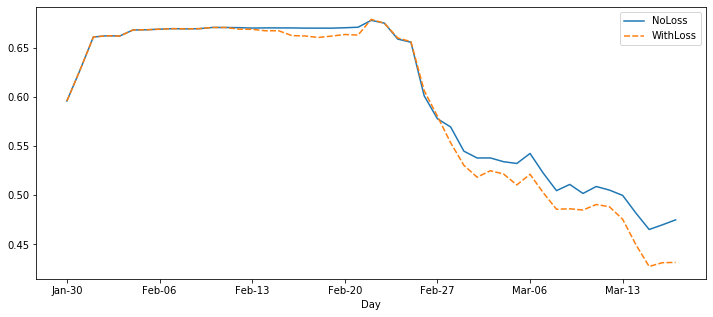

In [341]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
week = mdates.WeekdayLocator(interval=1)  # every year
months = mdates.MonthLocator()  # every month
month_fmt = mdates.DateFormatter('%b-%d')
ax = sns.lineplot(data=df_model_corr)

ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(month_fmt)

plt.savefig('img/model_correlation.svg')

Cria o dataframe a ser utilizado e roda o gridsearch

In [342]:
state_df_final = model_spread2(tplFinal1[0], tplFinal1[1])

print(state_df_final.sum())

state_df_final.sort_values('CasesPredicted', ascending=False)

Total    0.0
dtype: float64


KeyError: 'CasesPredicted'

In [ ]:
print(daily_cases.sum())

daily_cases.sort_values('n_cases', ascending=False)

In [ ]:
#pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])
pearsonr(state_df_final['CasesPredicted'].values, daily_cases['n_cases'].values)

In [ ]:
#daily_cases.rename_axis("source").index
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

In [ ]:
#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

#daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

#daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

#daily_cases

In [ ]:
df_results = state_df_final.join(daily_cases)

df_results['Residuals'] = df_results['n_cases'] - df_results['CasesPredicted']

df_results['ResidualsAbs'] = df_results['Residuals'].abs()

df_results.sort_values('Residuals')

In [ ]:
df_results.corr()

In [ ]:
df_results.drop('China').corr()

In [ ]:
df_results.corr(method='kendall')

In [ ]:
df_results.drop('China').plot.scatter(x='CasesPredicted', y='n_cases')

In [ ]:
#state_df_final.join(daily_cases).drop('China').corr(method='kendall')

In [ ]:
#correlation_pivot = correlation_df.pivot(index='P', columns='R', values='Euclidean Distance')
#correlation_pivot

In [ ]:
#heatmap = sns.heatmap(correlation_pivot.iloc[:,5:6], annot=True)